In [1]:
import warnings

warnings.filterwarnings("ignore")

## Quickstart

* here's some monthly historic sales data
* typical retail use case - goal is to predict sales count in future months

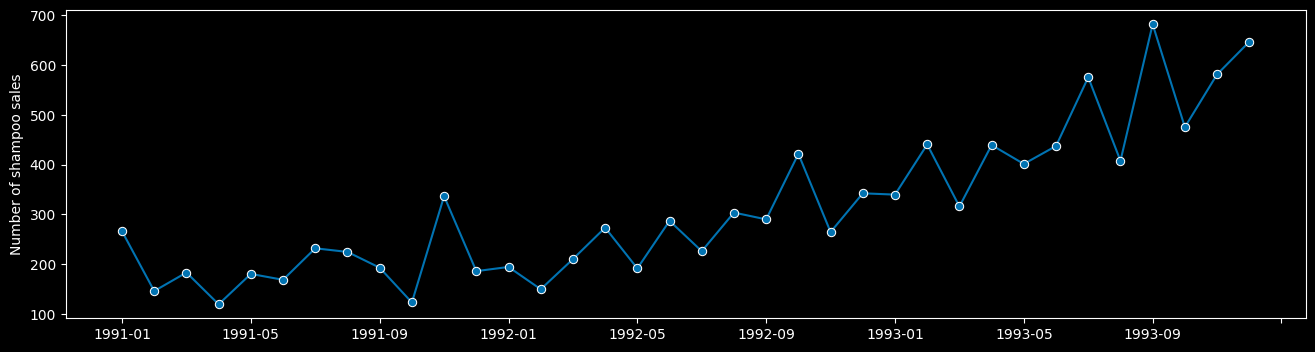

In [2]:
from sktime.datasets import load_shampoo_sales
from sktime.utils import plot_series

y = load_shampoo_sales()

_ = plot_series(y)

In [3]:
y.head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

let's split intro train+test subsets

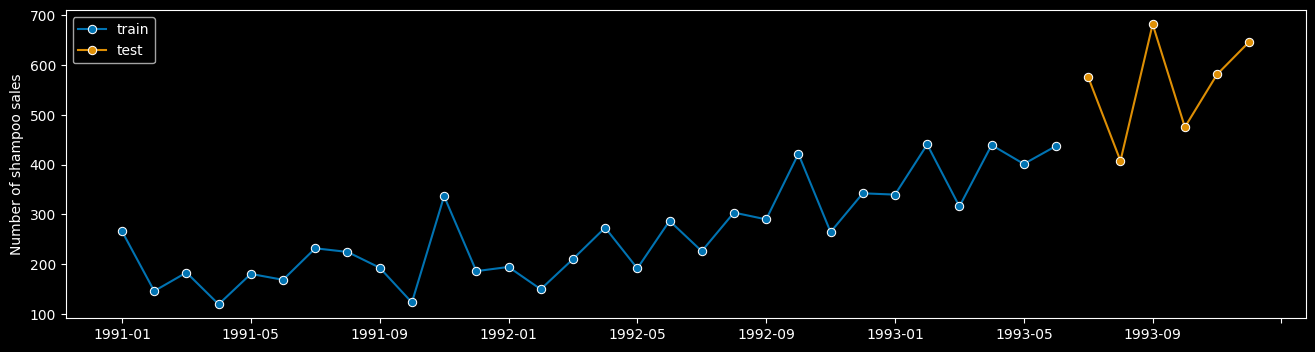

In [4]:
from sktime.split import temporal_train_test_split

y_train, y_test = temporal_train_test_split(y, test_size=6)

_ = plot_series(y_train, y_test, labels=["train", "test"])

In [5]:
y_train.head()

1991-01    266.0
1991-02    145.9
1991-03    183.1
1991-04    119.3
1991-05    180.3
Freq: M, Name: Number of shampoo sales, dtype: float64

In [6]:
y_test.head()

1993-07    575.5
1993-08    407.6
1993-09    682.0
1993-10    475.3
1993-11    581.3
Freq: M, Name: Number of shampoo sales, dtype: float64

we can use the exponential smoothing model, and make the modelling choice of error, trend and seasonality automated using an information criterion.

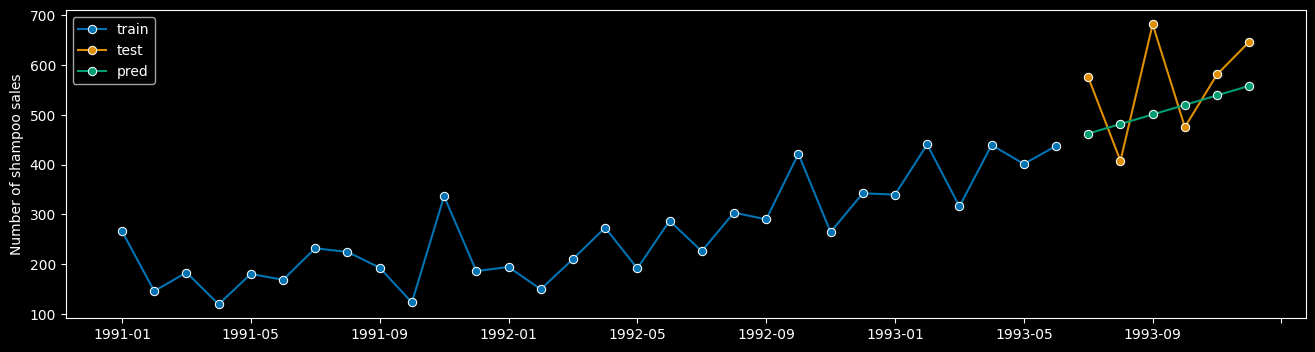

In [7]:
from sktime.forecasting.ets import AutoETS

# 1) Define the model
forecaster = AutoETS(auto=True)

# 2) Fit on train data
forecaster.fit(y_train)

# 3) Use fitted model to predict for a certain forecast horizon (fh)
fh = [1, 2, 3, 4, 5, 6]  # Relative to y_train
y_pred = forecaster.predict(fh=fh)

_ = plot_series(y_train, y_test, y_pred, labels=["train", "test", "pred"])

* scoring using `sktime` performance metrics
* requires forecasts & true values as `sktime` compatible time series

In [8]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

smape = MeanAbsolutePercentageError(symmetric=True)

print(f"AutoETS - sMAPE error: {smape(y_test, y_pred):.1%}")

AutoETS - sMAPE error: 16.7%


Notes:

* MAPE just for illustration - not always best choice
* for robust evaluation & comparison, use backtesting (not single train/test split)

## Exogenous Features

* we shall use classic Longley dataset
* our target variable of interest will be number of employed people
* other available features are various US macroeconomic features, known to be highly collinear

In [9]:
from sktime.datasets import load_longley

y, X = load_longley()

In [10]:
y.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [11]:
X.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [12]:
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X=X, test_size=4)

In [13]:
y_train.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [14]:
y_train.head()

Period
1947    60323.0
1948    61122.0
1949    60171.0
1950    61187.0
1951    63221.0
Freq: A-DEC, Name: TOTEMP, dtype: float64

In [15]:
X_train.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0


In [16]:
X_test.head()

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1959,112.6,482704.0,3813.0,2552.0,123366.0
1960,114.2,502601.0,3931.0,2514.0,125368.0
1961,115.7,518173.0,4806.0,2572.0,127852.0
1962,116.9,554894.0,4007.0,2827.0,130081.0


we will use `ARIMA` estimator, which is built on top of `statsmodels` implementation of SARIMAX

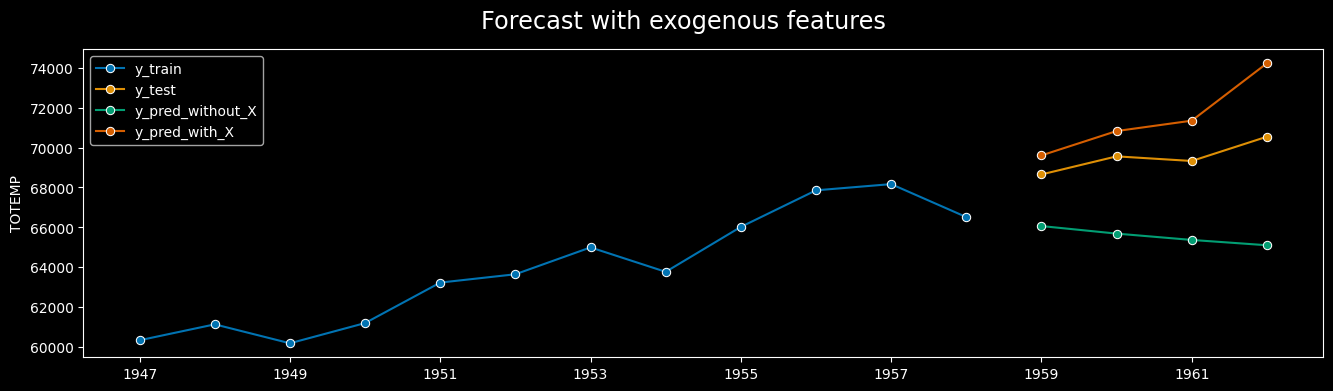

In [17]:
from sktime.forecasting.arima import ARIMA

forecaster_without_X = ARIMA()
forecaster_with_X = ARIMA()

forecaster_without_X.fit(y_train)
forecaster_with_X.fit(y_train, X=X_train)

fh = [1, 2, 3, 4]

y_pred_without_X = forecaster_without_X.predict(fh=fh)
y_pred_with_X = forecaster_with_X.predict(X=X_test, fh=fh)

_ = plot_series(
    y_train,
    y_test,
    y_pred_without_X,
    y_pred_with_X,
    labels=["y_train", "y_test", "y_pred_without_X", "y_pred_with_X"],
    title="Forecast with exogenous features",
)

In [18]:
print(f"ARIMA without X - sMAPE error: {smape(y_test, y_pred_without_X):.1%}")

ARIMA without X - sMAPE error: 5.9%


In [19]:
print(f"ARIMA with X - sMAPE error: {smape(y_test, y_pred_with_X):.1%}")

ARIMA with X - sMAPE error: 2.8%


all forecasters that support exogenous features

In [20]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"ignores-exogeneous-X": True},
    as_dataframe=True,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
2,BATS,<class 'sktime.forecasting.bats.BATS'>
3,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
4,CurveFitForecaster,<class 'sktime.forecasting.trend._curve_fit_fo...
5,DirRecTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
6,DirRecTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
7,ExponentialSmoothing,<class 'sktime.forecasting.exp_smoothing.Expon...
8,ForecastKnownValues,<class 'sktime.forecasting.dummy.ForecastKnown...
9,ForecastingGridSearchCV,<class 'sktime.forecasting.model_selection._tu...


## Multivariate forecasting

We begin by loading the historical data of a couple of macro indicators, which are reported yearly.

In [21]:
y = X[["GNPDEFL", "GNP"]]

In `sktime` some forecasters such as `VAR()` are purely mutlivariate. Let's use it to make some predictions:

In [22]:
from sktime.forecasting.var import VAR

forecaster = VAR()
forecaster.fit(y)

y_pred = forecaster.predict(fh=[1, 2, 3])
y_pred

,GNPDEFL,GNP
Period,,
1963,121.688295,578514.398653
1964,124.353664,601873.015890
1965,126.847886,625411.588754


here are all the forecasters that support multivariate endogenous features natively

In [23]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"scitype:y": "multivariate"},
    as_dataframe=True,
)

,name,object
0,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
1,VAR,<class 'sktime.forecasting.var.VAR'>
2,VARMAX,<class 'sktime.forecasting.varmax.VARMAX'>
3,VECM,<class 'sktime.forecasting.vecm.VECM'>


But we can also use univariate forecasters to forecast multiple time series! Let's see how this is done using Theta forecasting which is a purely univariate model.

In [24]:
from sktime.forecasting.theta import ThetaForecaster

forecaster = ThetaForecaster()
forecaster.fit(y)

y_pred = forecaster.predict(fh=[1, 2, 3])
y_pred

/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,GNPDEFL,GNP
Period,,
1963,119.146618,575540.647081
1964,120.269926,585929.865464
1965,121.393235,596319.083846


this is done by separate models per each of the columns

In [25]:
forecaster.forecasters_

,GNPDEFL,GNP
forecasters,ThetaForecaster(),ThetaForecaster()


## Probabilistic Forecasting

The following methods are possibly available for probabilistic forecasts:

- `predict_interval` produces interval forecasts. Additionally to any `predict` arguments, an argument `coverage` (nominal interval coverage) must be provided.
- `predict_quantiles` produces quantile forecasts. Additionally to any `predict` arguments, an argument `alpha` (quantile values) must be provided.
- `predict_var` produces variance forecasts. This has same arguments as `predict`.
- `predict_proba` produces full distributional forecasts. This has same arguments as `predict`.

| Name | param | prediction/estimate of | `sktime` |
| ---- | ----- | ---------------------- | -------- |
| point forecast | | conditional expectation $\mathbb{E}[y'\|y]$ | `predict` |
| variance forecast | | conditional variance $Var[y'\|y]$ | `predict_var` |
| quantile forecast | $\alpha\in (0,1)$ | $\alpha$-quantile of $y'\|y$ | `predict_quantiles` |
| interval forecast | $c\in (0,1)$| $[a,b]$ s.t. $P(a\le y' \le b\| y) = c$ | `predict_interval` |
| distribution forecast | | the law/distribution of $y'\|y$ | `predict_proba` |

In [26]:
y_pred_int = forecaster.predict_interval(coverage=0.95)

y_pred_int

GNPDEFL                        GNP               
              0.95                       0.95               
             lower       upper          lower          upper
Period                                                      
1963    111.144138  127.149097  503478.824106  647602.470057
1964    110.468931  130.070922  497746.279833  674113.451094
1965    110.076020  132.710450  494536.063558  698102.104134

* what if you want for multiple coverages?
* no problem, just pass a list

In [27]:
y_pred_int_multiple = forecaster.predict_interval(coverage=[0.95, 0.9])

y_pred_int_multiple

GNPDEFL                                                GNP  \
              0.95                    0.90                       0.95   
             lower       upper       lower       upper          lower   
Period                                                                  
1963    111.144138  127.149097  112.430725  125.862510  503478.824106   
1964    110.468931  130.070922  112.044672  128.495181  497746.279833   
1965    110.076020  132.710450  111.895529  130.890942  494536.063558   

                                                     
                                0.90                 
                upper          lower          upper  
Period                                               
1963    647602.470057  515064.458835  636016.835328  
1964    674113.451094  511923.867493  659935.863434  
1965    698102.104134  510900.080536  681738.087156

here are the forecasters that support probabilistic capabilities.

In [28]:
from sktime.registry import all_estimators

all_estimators(
    estimator_types="forecaster",
    filter_tags={"capability:pred_int": True},
    as_dataframe=True,
)

,name,object
0,ARCH,<class 'sktime.forecasting.arch._uarch.ARCH'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,BATS,<class 'sktime.forecasting.bats.BATS'>
5,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.Ba...
6,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
7,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
8,DynamicFactor,<class 'sktime.forecasting.dynamic_factor.Dyna...
9,FhPlexForecaster,<class 'sktime.forecasting.compose._fhplex.FhP...


# Forecasting Pipelines

Until now: How can we use sktime to create forecasts.

Now: How can we improve the forecasts.

* endogenous transformation pipelines via `TransformedTargetForecaster`
* parameter estimation using ``
* forecasting exogenous variables via `ForecastX`

### Transformation pipelines

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

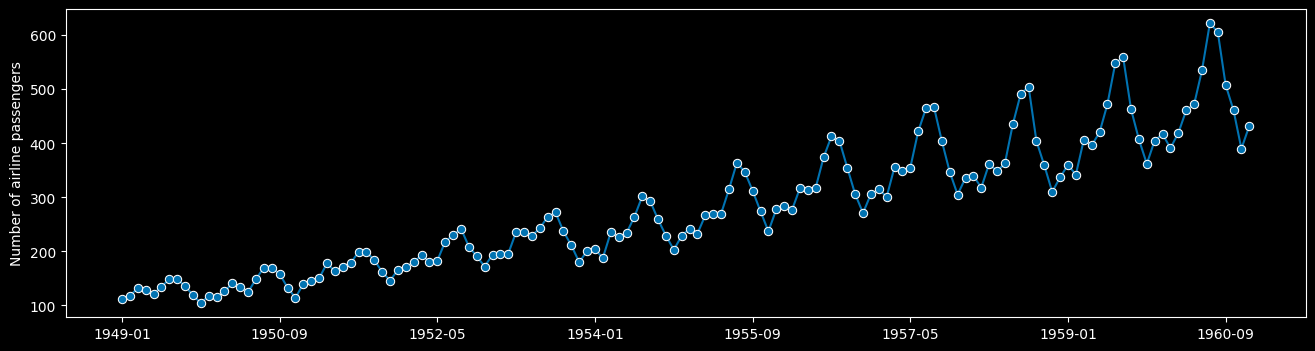

In [29]:
from sktime.datasets import load_airline
from sktime.utils import plot_series

y = load_airline()
_ = plot_series(y)

observations:

* there is monthly seasonality - resets annually - periodicity 12
* trend and seasonality are multiplicative (not additive)

ideas:

* on logarithmic value scale (multiplication becomes addition)
* with seasonality removed

let's see how one will achieve this manually in a complicated sequesce of steps, and then we'll take a look at how `sktime` can help to make this much simpler.

#### Manual transformations: doing things the hard way

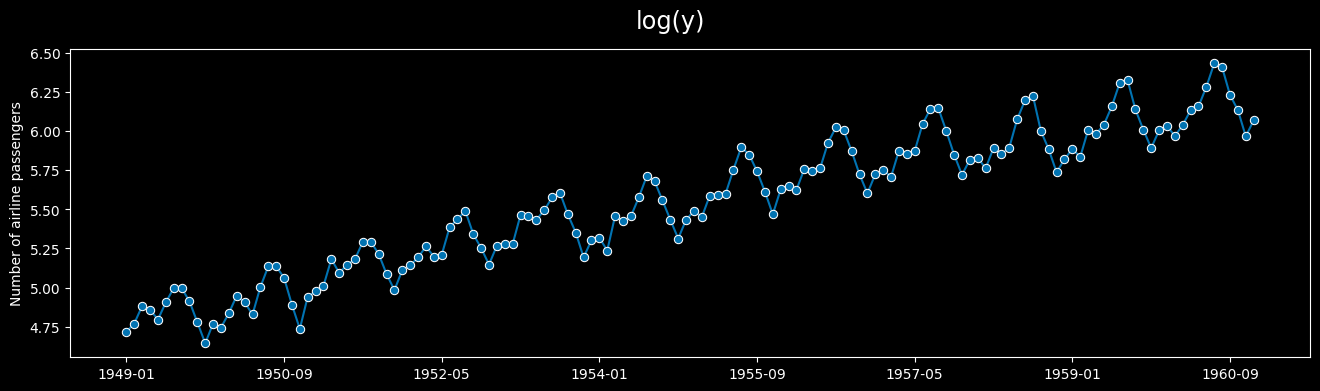

In [30]:
import numpy as np

y_log = np.log(y)

_ = plot_series(y_log, title="log(y)")

this looks additive now!

ok, what next - deaseasonalization

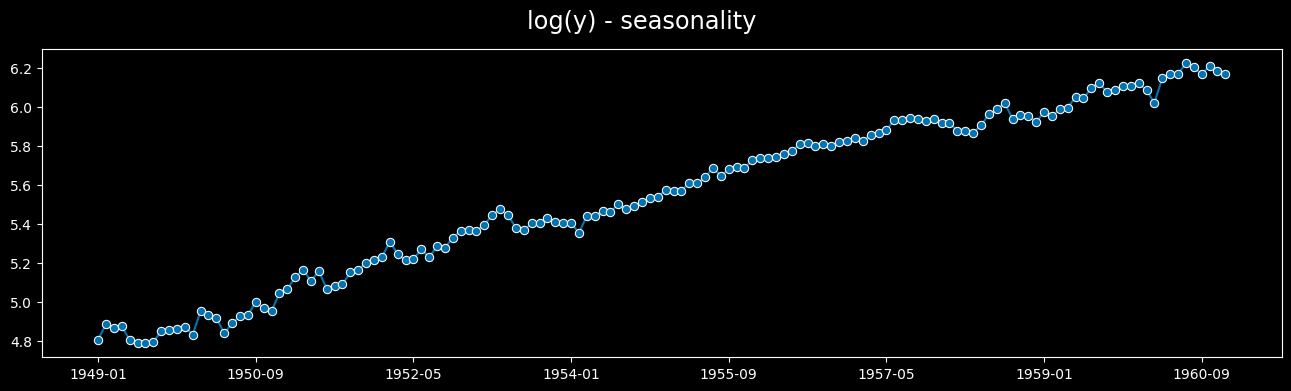

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_result = seasonal_decompose(y_log, period=12)
seasonal = seasonal_result.seasonal
y_log_deseasonalised = y_log - seasonal

_ = plot_series(y_log_deseasonalised, title="log(y) - seasonality")

now:

* forecast on this
* add back seasonal component
* invert logarithm (exponentiate)

start with forecast...

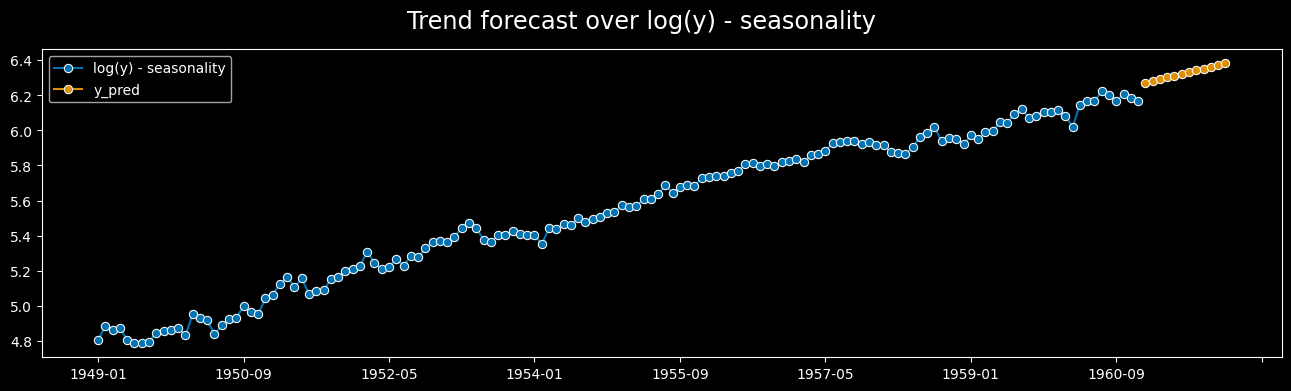

In [32]:
from sktime.forecasting.trend import TrendForecaster

forecaster = TrendForecaster()  # uses OLS by default to fit a linear model

fh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Alternatively: range(1, 12 + 1)
y_pred = forecaster.fit_predict(y_log_deseasonalised, fh=fh)

_ = plot_series(
    y_log_deseasonalised,
    y_pred,
    labels=["log(y) - seasonality", "y_pred"],
    title="Trend forecast over log(y) - seasonality",
)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

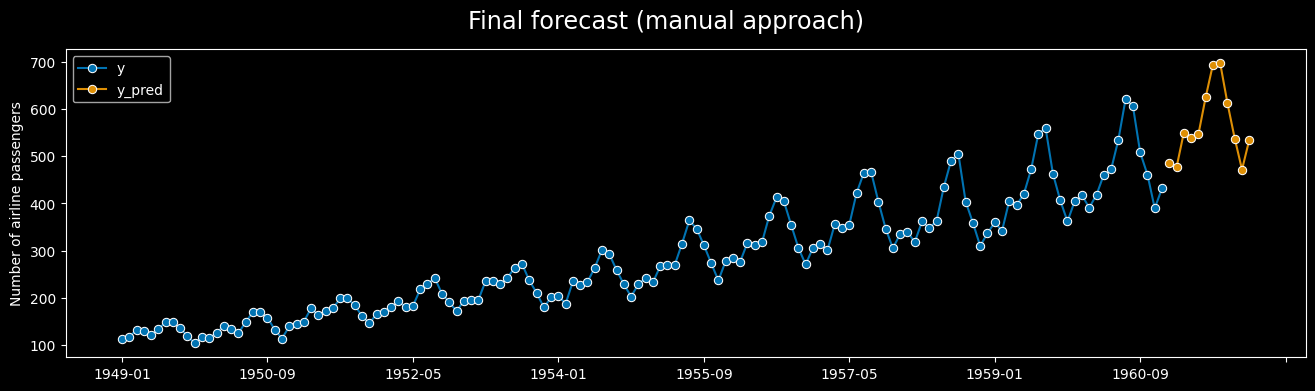

In [33]:
y_pred_add_seasonality = y_pred + seasonal.to_numpy()[:12]
y_pred_orig = np.exp(y_pred_add_seasonality)

_ = plot_series(
    y, y_pred_orig, labels=["y", "y_pred"], title="Final forecast (manual approach)"
)

#### `sktime` transformers: doing things the easier way

Solution: use transformers & pipelines!

Same interface at every step! Easily composable!

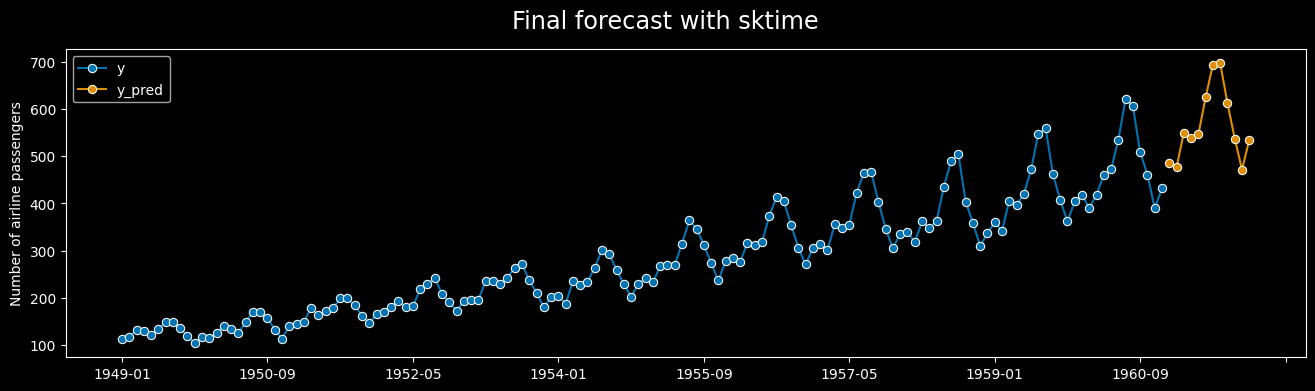

In [34]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import TrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

take_log = LogTransformer()
remove_seasonality = Deseasonalizer(sp=12)
trend_forecaster = TrendForecaster()

forecaster_explicit = TransformedTargetForecaster(
    [take_log, remove_seasonality, trend_forecaster]
)

fh = range(1, 12 + 1)
y_pred = forecaster_explicit.fit_predict(y, fh=fh)

_ = plot_series(y, y_pred, labels=["y", "y_pred"], title="Final forecast with sktime")

### Dunder magic

In [35]:
forecaster_dunder = take_log * remove_seasonality * trend_forecaster

forecaster_dunder

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   TrendForecaster()])

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

### Parameter Estimation

* what if you don't know seasonal periodicity

In [36]:
from sktime.param_est.seasonality import SeasonalityACF
from sktime.transformations.series.difference import Differencer

# compute seasonality on first differences - to make the series stationary first
sp_est = Differencer() * SeasonalityACF()
sp_est.fit(y)

sp_est.get_fitted_params()

{'acf': array([ 1.        ,  0.30279009, -0.10230424, -0.24118718, -0.30023417,
        -0.09421319, -0.07857897, -0.09232524, -0.29459306, -0.19150615,
        -0.10467597,  0.2827635 ,  0.82922657,  0.2843692 , -0.10592295,
        -0.22200376, -0.23088304, -0.06256116, -0.06643473, -0.0903648 ,
        -0.2969042 , -0.16234839]),
 'confint': array([[ 1.        ,  1.        ],
        [ 0.13945976,  0.46612043],
        [-0.27997909,  0.07537061],
        [-0.42042657, -0.06194778],
        [-0.48793181, -0.11253652],
        [-0.29431249,  0.1058861 ],
        [-0.27985813,  0.12270019],
        [-0.29442112,  0.10977063],
        [-0.49781098, -0.09137513],
        [-0.40581392,  0.02280162],
        [-0.32350134,  0.1141494 ],
        [ 0.06260642,  0.50292058],
        [ 0.59958547,  1.05886768],
        [-0.01466569,  0.58340408],
        [-0.41208687,  0.20024097],
        [-0.52914372,  0.0851362 ],
        [-0.54227431,  0.08050823],
        [-0.37848622,  0.2533639 ],
      

and you can estimate and plug the value in a forecaster using `PluginParamsForecaster`

In [37]:
from sktime.forecasting.arima import AutoARIMA
from sktime.param_est.plugin import PluginParamsForecaster

forecaster = AutoARIMA()

# can control names using `params`
pipeline = PluginParamsForecaster(sp_est, forecaster)

pipeline.fit_predict(y, fh=fh)

/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1961-01    451.347077
1961-02    427.102222
1961-03    463.382490
1961-04    499.705771
1961-05    514.035525
1961-06    571.851867
1961-07    661.310509
1961-08    648.081675
1961-09    551.284691
1961-10    501.068279
1961-11    434.052984
1961-12    479.233768
Freq: M, Name: Number of airline passengers, dtype: float64

let's verify that estimated periodicty is used in forecaster

In [38]:
pipeline.forecaster_

AutoARIMA(sp=12)

### Exogenous predictions

what if you want to use exogenous features, but don't have values during forecast horizon?

...predict `X` first with `ForecastX`, and then pass the estimates to forecaster for `y`

let's load Longley dataset

In [39]:
from sktime.datasets import load_longley

y, X = load_longley()

and split into train+test

In [40]:
from sktime.split import temporal_train_test_split

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X=X, test_size=4)

let's model 3 times

* without X
* with X, by passing known values during both training and prediction phases
* with X, but passing known values only for training

In [41]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import ForecastX
from sktime.forecasting.var import VAR

forecaster_without_X = ARIMA()
forecaster_with_X_known = ARIMA()
forecaster_with_X_unknown = ForecastX(ARIMA(), VAR())

fh = [1, 2, 3, 4]

forecaster_without_X.fit(y_train)
forecaster_with_X_known.fit(y_train, X=X_train)
forecaster_with_X_unknown.fit(y_train, X=X_train, fh=fh)

y_pred_without_X = forecaster_without_X.predict(fh=fh)
y_pred_with_X_known = forecaster_with_X_known.predict(X=X_test, fh=fh)
y_pred_with_X_unknown = forecaster_with_X_unknown.predict()

and let's plot now

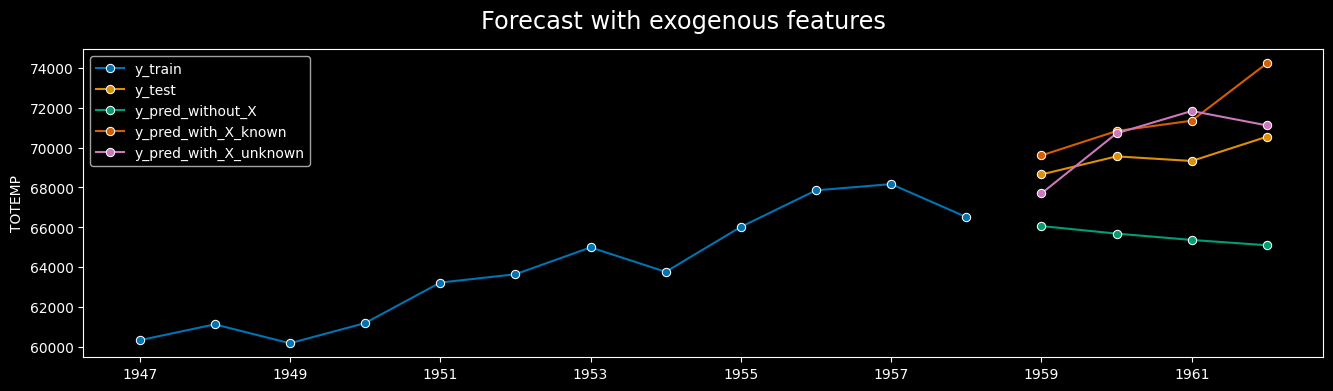

In [42]:
from sktime.utils import plot_series

_ = plot_series(
    y_train,
    y_test,
    y_pred_without_X,
    y_pred_with_X_known,
    y_pred_with_X_unknown,
    labels=[
        "y_train",
        "y_test",
        "y_pred_without_X",
        "y_pred_with_X_known",
        "y_pred_with_X_unknown",
    ],
    title="Forecast with exogenous features",
)

## Parameter tuning

* we want to use a specific forecaster, but not sure about the optimal hyperparameters
* we can use grid or random search - similar interface with `sklearn` with minor adjustments

let's go back to shampoo sales, and split into train+test subsets.

In [43]:
from sktime.datasets import load_shampoo_sales
from sktime.split import temporal_train_test_split

y = load_shampoo_sales()

y_train, y_test = temporal_train_test_split(y, test_size=6)

this time we'll find best parameters ourselves. let's initiate the estimator.

In [44]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=False)

we shall try to find the best combination of the following hyperparameters

In [45]:
param_grid = {
    "error": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
    "seasonal": ["add", "mul"],
    "sp": [4, 6, 12],
}

and now let's create different cross validation splits

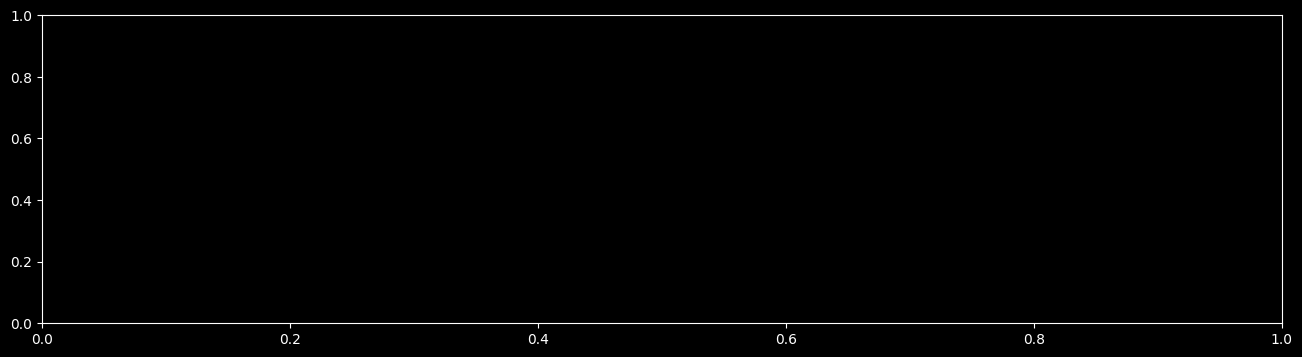

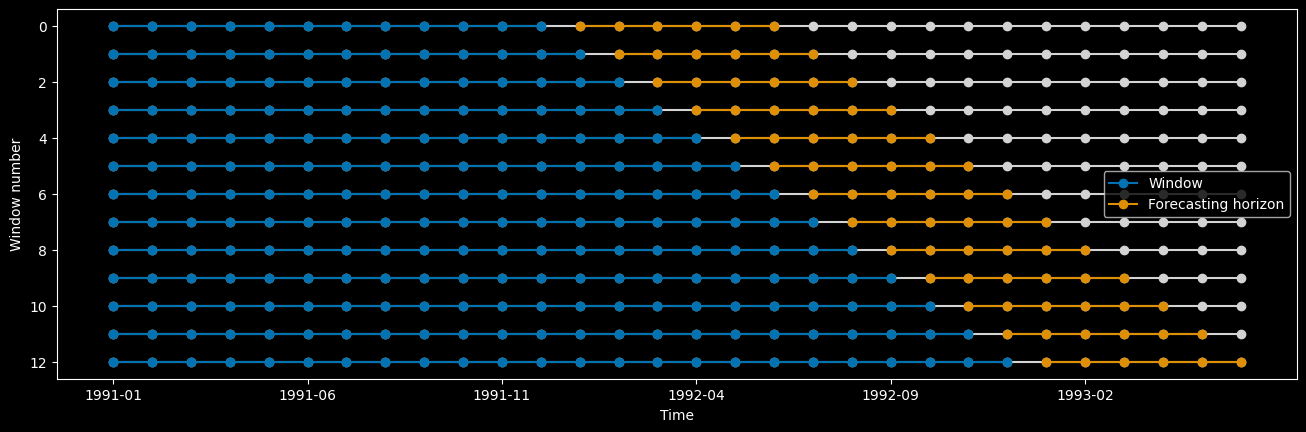

In [46]:
from sktime.split import ExpandingWindowSplitter
from sktime.utils import plot_windows

cv = ExpandingWindowSplitter(fh=range(1, 6 + 1), initial_window=12, step_length=1)
_ = plot_windows(cv, y_train)

let's get into the tuning now

In [47]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV

gscv = ForecastingGridSearchCV(
    forecaster, cv, param_grid, scoring=smape, n_jobs=-1
)
gscv.fit(y_train)

/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/sktime/utils/parallel.py:83: FitFailedWarning: 
                In evaluate, fitting of forecaster AutoETS failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff NaT, and len(y_train)=12.
                The score will be set to nan.
                Failed forecaster with parameters: AutoETS(damped_trend=True, seasonal='add', sp=12, trend='add').
                
  ret = [fun(x, meta=meta) for x in iter]
/home/anirban/conda-environments/pydata/lib/python3.11/site-packages/sktime/utils/parallel.py:83: FitFailedW

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(fh=range(1, 7),
                                                   initial_window=12),
                        forecaster=AutoETS(), n_jobs=-1,
                        param_grid={'damped_trend': [True, False],
                                    'error': ['add', 'mul'],
                                    'seasonal': ['add', 'mul'],
                                    'sp': [4, 6, 12], 'trend': ['add', 'mul']},
                        scoring=MeanAbsolutePercentageError(symmetric=True))

this can be used for prediction directly

In [48]:
gscv.predict(fh=range(1, 6 + 1))

1993-07    474.133441
1993-08    455.192671
1993-09    512.694378
1993-10    515.249077
1993-11    523.214253
1993-12    550.843171
Freq: M, Name: Number of shampoo sales, dtype: float64

and we can find the optimal hyperparameters, best metrics etc. from `best_*` attributes.

In [49]:
gscv.best_params_

{'damped_trend': False,
 'error': 'add',
 'seasonal': 'add',
 'sp': 12,
 'trend': 'mul'}

In [50]:
gscv.best_score_

0.08967758059495695